In [1]:
import cvxpy
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')

from skyburst import Job

def solver(arrivals, runtimes, sizes, total_waiting, num_nodes):
    num_jobs = len(runtimes)
    nodes = np.array([1]*num_jobs)
    costs = runtimes * sizes
    
    bin_width = QUANT_COUNT
    bin_height = 1e6

    jobs_proc = []
    for idx in range(num_jobs):
        jobs_proc.append(Job(idx = idx, arrival = arrivals[idx], runtime = runtimes[idx],
                     deadline = None, resources = {'GPUs': sizes[idx]}, cost = costs[idx]))

    # MILP
    waits =  cvxpy.Variable((num_jobs,))
    deadlines = arrivals + waits + runtimes
    left = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    bottom = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    selection =  cvxpy.Variable((num_nodes, num_jobs), boolean=True)
    x_w = cvxpy.Variable((num_jobs,), integer=True)
    y_h = cvxpy.Variable((num_jobs,))
    all_or_nothing = cvxpy.Variable((num_jobs,), boolean=True)

    constraints = []

    # Restriction on X,Y coordinates
    constraints.append(x_w >= 0)
    constraints.append(x_w <= bin_width - sizes)
    constraints.append(y_h >= arrivals)
    constraints.append(y_h <=deadlines - runtimes)
    constraints.append(waits <= total_waiting)
    #constraints.append(cvxpy.sum(waits) <= total_waiting)
    constraints.append(waits >= 0)
    # Restriction on selection
    constraints.append(cvxpy.sum(selection, axis=0) == cvxpy.multiply(nodes, all_or_nothing))

    # Restriction on Boxes not intersecting
    triangle_filter = 100*np.triu(np.ones((num_jobs, num_jobs)))
    var_filter = triangle_filter + left + left.T + bottom + bottom.T 

    # Add constraints for each node boxes
    for n_idx in range(num_nodes):
        row = selection[n_idx]
        outer_sum = cvxpy.reshape(row, (num_jobs, 1)) + cvxpy.reshape(row, (1, num_jobs))
        constraints.append(var_filter + (2 - outer_sum) >=1)

    eq_1 = cvxpy.reshape(x_w + sizes, (num_jobs, 1)) - cvxpy.reshape(x_w, (1, num_jobs)) + bin_width * left <= bin_width 
    eq_2 = cvxpy.reshape(y_h + runtimes, (num_jobs, 1)) - cvxpy.reshape(y_h, (1, num_jobs)) + bin_height * bottom <= bin_height
    constraints.append(eq_1)
    constraints.append(eq_2)
    # Our total utility is the sum of the item utilities
    total_utility = cvxpy.sum(selection@costs)

    super_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)
    # Solving the problem
    opts = {'limits/time' : 60, 'parallel/minnthreads': 32, 'parallel/maxnthreads': 63} #{'maxiters' : 5000}
    super_problem.solve(solver=cvxpy.SCIP, verbose=False, scip_params = opts)
    selection_sol = selection.value
    print(selection.value)
    check_local = np.sum(selection_sol, axis=0)
    waits_sol = waits.value
    start_sol = y_h.value
    allocated_gpus = x_w.value
    total_cost = 0
    for idx in range(num_jobs):
        cur_job = jobs_proc[idx]
        if check_local[idx] != 0:
            cur_job.state = 'LOCAL' 
            cur_job.start = start_sol[idx]
            cur_job.allocated_gpus[0] = list(range(int(x_w.value[idx]), int(x_w.value[idx]) + cur_job.num_gpus))   
        else:
            cur_job.state = 'TIMEOUT_CLOUD'
            total_cost += costs[idx]
    print(f'Total Cost: {total_cost}')
    return jobs_proc

def plot_trace_spacetime_and_spillover(jobs, num_nodes, rescale=None):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]
    fig, ax = plt.subplots(figsize=(20, 10))
    total_gpus = num_nodes * QUANT_COUNT
    segment_height_list = {}
    for j_idx in range(len(jobs)):
        allocated_gpus = jobs[j_idx].allocated_gpus
        if not allocated_gpus:
            height = 1
            segment = (jobs[j_idx].arrival,
                       jobs[j_idx].arrival + jobs[j_idx].runtime, j_idx)
            for k, v in segment_height_list.items():
                if segment[0] > k[0] and segment[0] < k[1]:
                    height += v
            segment_height_list[segment] = jobs[j_idx].num_gpus
            ax.barh(total_gpus + height,
                    width=segment[1] - segment[0],
                    edgecolor='black',
                    height=jobs[j_idx].num_gpus,
                    left=segment[0],
                    align='edge',
                    color=colors[j_idx])
        else:
            for node_idx in allocated_gpus.keys():
                for node_gpu_idx in allocated_gpus[node_idx]:
                    gpu_idx = total_gpus - (QUANT_COUNT * node_idx +
                                            node_gpu_idx)
                    #                 print(job.idx)
                    #                 print(len(colors))
                    ax.barh(gpu_idx,
                            width=jobs[j_idx].runtime,
                            edgecolor='black',
                            height=1.0,
                            left=jobs[j_idx].start,
                            align='edge',
                            color=colors[j_idx])
    for i in range(total_gpus + 1):
        multiplier = math.ceil(num_nodes / 32)
        if (i + 1) % QUANT_COUNT == 1:
            plt.axhline(y=i + 1, linewidth=8 / multiplier, color='brown')
        else:
            pass
    if rescale:
        xmin, xmax = plt.xlim()
        if xmax > rescale[0]:
            plt.xlim(left=0)
        else:
            plt.xlim(left=0, right=rescale[0])
        plt.ylim(bottom=1, top=rescale[1])
    else:
        plt.ylim(bottom=1)  #, #top=total_gpus + 1)
        plt.xlim(left=0)
    #plt.xlim(right=1.1 * max_arrival)
    #plt.axvline(x=10, color='black', linewidth=5)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    print(xmax, ymax)
    plt.tight_layout()
    plt.show()
    return xmax, ymax

In [2]:
QUANT_COUNT = 2
arrivals = np.cumsum(np.random.exponential(0.5, 40))
runtimes = np.random.exponential(1.0, 40)

sizes = np.array([1]*len(runtimes))
total_waiting = np.sum(runtimes)*0.25
num_nodes = 1

In [3]:
no_wait_proc = solver(arrivals, runtimes, sizes, 0.01, 1)

with_wait_proc = solver(arrivals, runtimes, sizes, [0.25*r for r in runtimes], 1)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]]
Total Cost: 7.091204168462562
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.]]
Total Cost: 5.1047974987445075


35.0 9.0


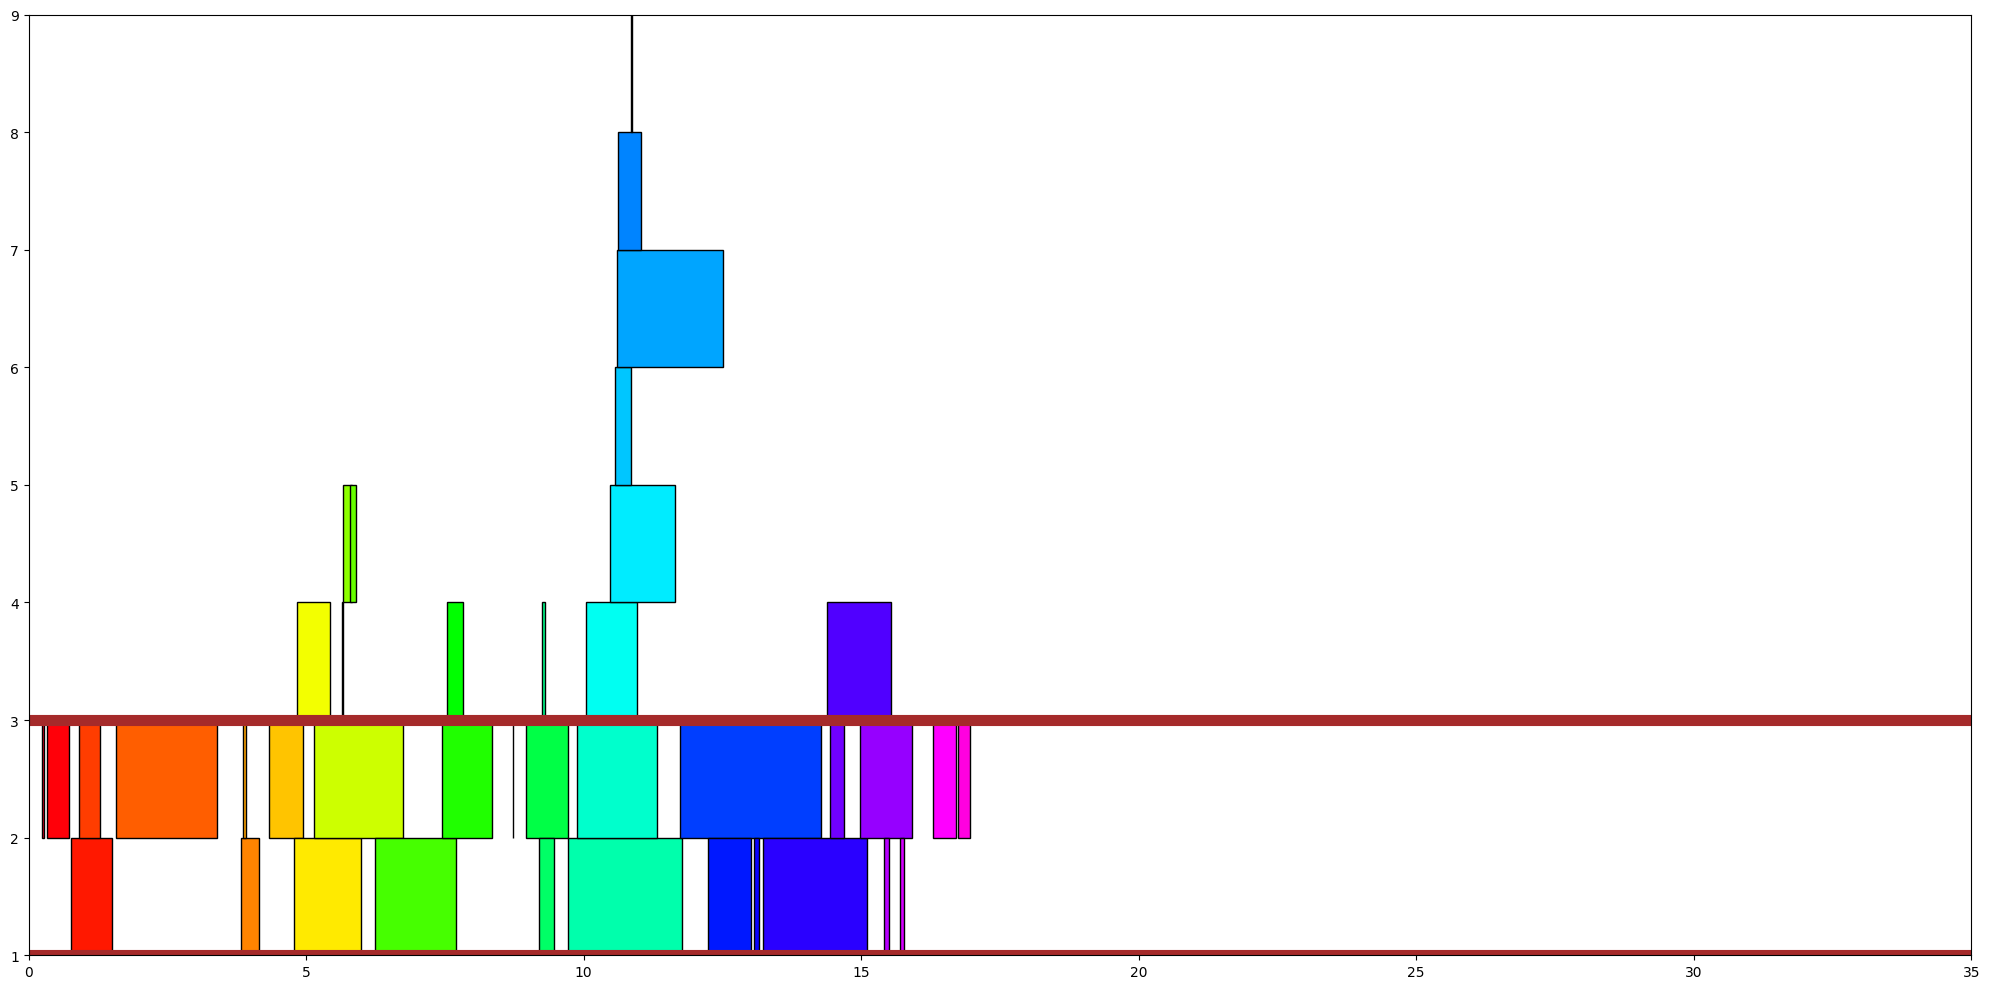

35.0 9.0


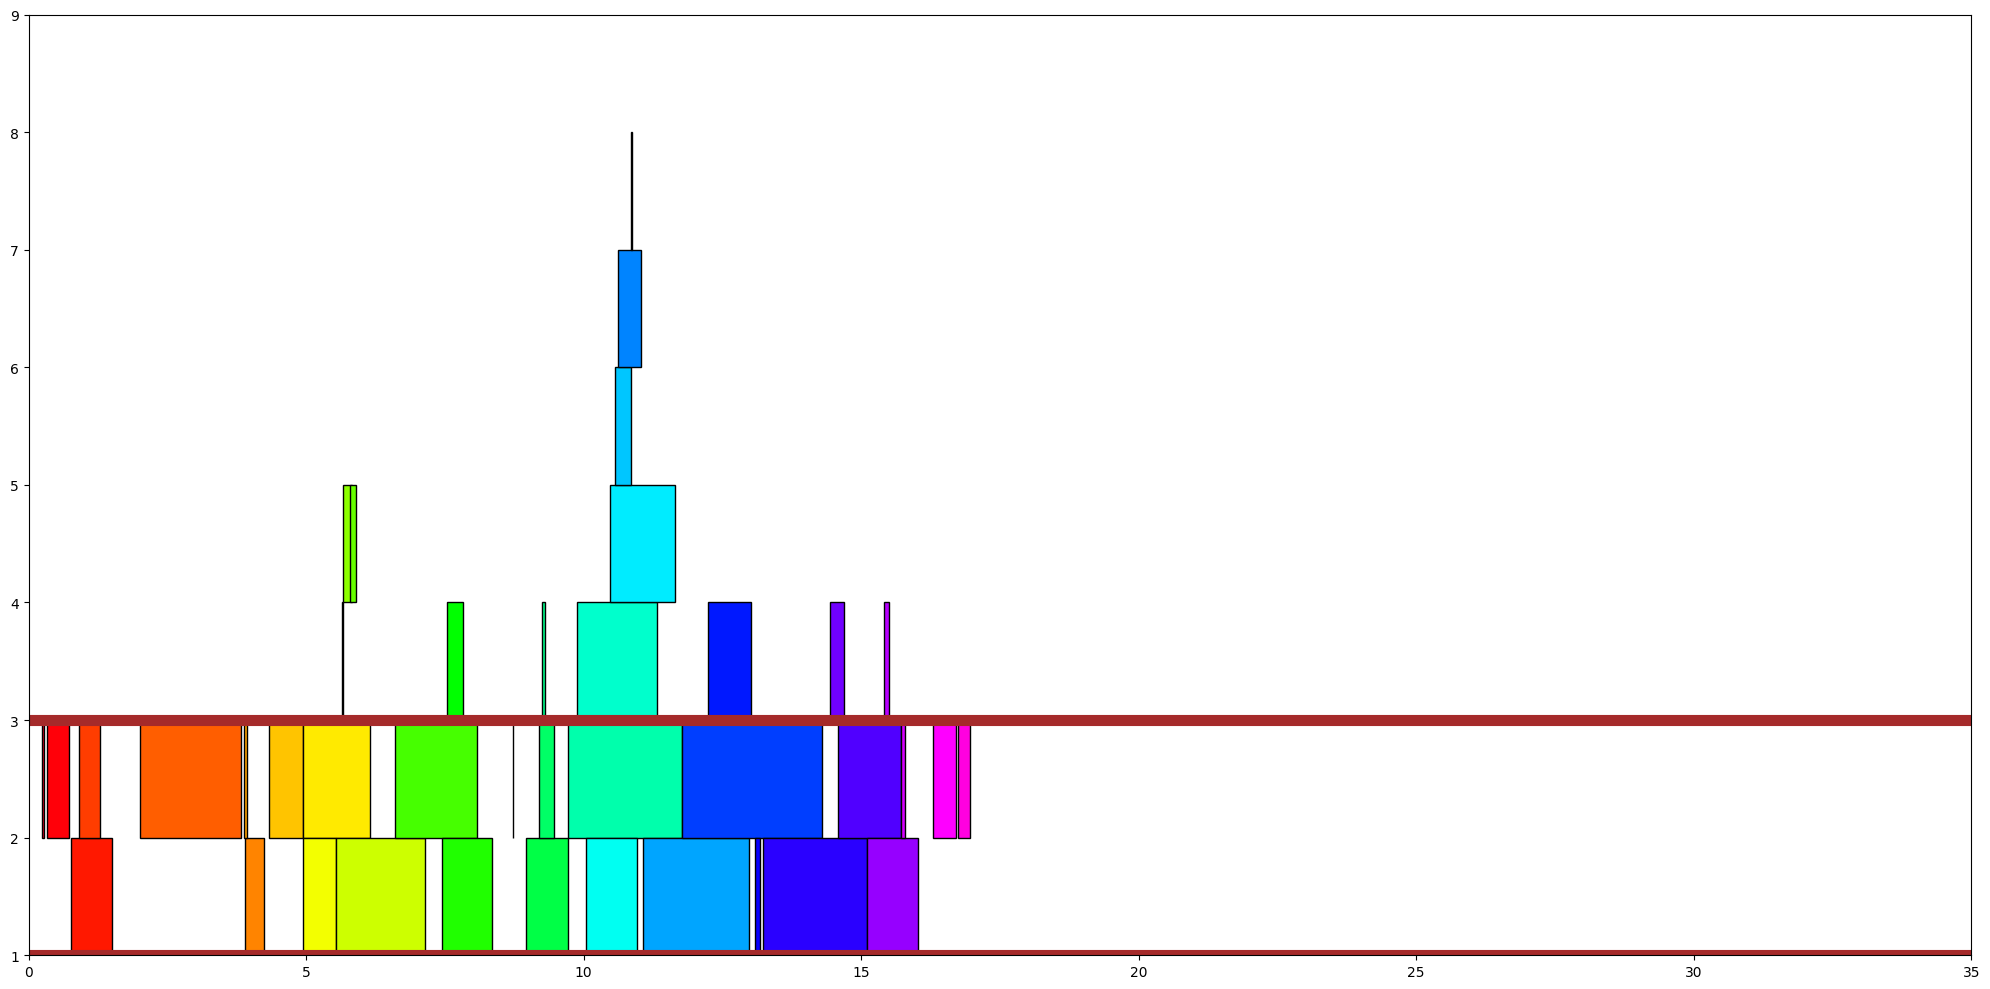

(35.0, 9.0)

In [4]:
plot_trace_spacetime_and_spillover(no_wait_proc, num_nodes, rescale=(35, 9))

plot_trace_spacetime_and_spillover(with_wait_proc, num_nodes, rescale=(35,9))